In [1]:
import os
import numpy as np
from core.data_provider import datasets_factory
from core.models.model_factory import Model
from core.utils import preprocess
import core.trainer as trainer
import math 
# export CUDA_VISIBLE_DEVICES=0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/xiao/anaconda3/envs/pytorch19/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
class configs:
    is_training = 0
    device = "cuda"
    dataset_name = "motion"
    train_data_paths = "/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/normalized_train_video.npz"
    valid_data_paths = "/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/normalized_test_seen_video.npz"
    gen_frm_dir = "results/motion_predrnn"
    input_length = 1
    total_length = 12
    img_width = 64
    img_channel = 3
    model_name = "predrnn" #"predrnn_memory_decoupling"
    pretrained_model = "/home/xiao/Projects/predrnn-pytorch/models/RRT_star/predrnn/model.ckpt-57000"
    num_hidden = "64,64,64,64"
    filter_size = 5
    stride = 1
    patch_size = 4 
    layer_norm = 0
    lr = 0.0003
    batch_size = 1
    reverse_scheduled_sampling = 0
    num_save_samples = 10
    decouple_beta = 0.1
    visual = False
    visual_path = ""

In [3]:
import matplotlib.pyplot as plt
# train_video = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/train_video.npy")
# print ('train_video', train_video.shape)
test_seen_video = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/test_seen_video.npy")
test_seen_video = np.transpose(test_seen_video, (0,1,2,4,5,3))
print ('test_seen_video', test_seen_video.shape)
test_seen_config = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/test_seen_config.npy")
video_len = test_seen_video.shape[2]
frame_size = test_seen_video.shape[3]
frame_channel = test_seen_video.shape[-1]
print ('test_seen_config', test_seen_config.shape)
test_unseen_video = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/test_unseen_video.npy")
print ('test_unseen_video', test_unseen_video.shape)

test_seen_video (100, 200, 12, 64, 64, 3)
test_seen_config (100, 400, 4)
test_unseen_video (20, 400, 14, 3, 64, 64)


[[21 43 31 47]
 [43 12 51 20]
 [45 36 49 40]
 [49 16 55 22]
 [30 42 38 50]
 [28 30 38 34]
 [ 9 48 17 56]
 [15  6 23 12]
 [16 26 20 30]
 [ 7  5 17  9]
 [14 26 24 30]
 [53 46 57 50]
 [19 31 25 35]
 [22 37 30 43]
 [42 19 50 25]]
all_obs (120, 15, 4)


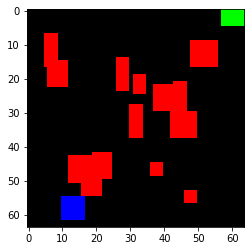

In [4]:
all_obs = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/obs.npy")
print (all_obs[0])
for i in range(all_obs.shape[0]):
    for j in range(all_obs.shape[1]):
        center_x = (all_obs[i,j,0] + all_obs[i,j,2])/2
        center_y = (all_obs[i,j,1] + all_obs[i,j,3])/2
        w = abs(all_obs[i,j,0] - all_obs[i,j,2])
        h = abs(all_obs[i,j,1] - all_obs[i,j,3])
        all_obs[i,j,0] = center_x
        all_obs[i,j,1] = center_y
        all_obs[i,j,2] = w
        all_obs[i,j,3] = h
print ('all_obs', all_obs.shape)
plt.imshow(test_seen_video[0,0,0,:])

In [5]:
model = Model(configs)
model.load(configs.pretrained_model)

load model: /home/xiao/Projects/predrnn-pytorch/models/RRT_star/predrnn/model.ckpt-57000


In [6]:
def augmentation(img, start_x, start_y):
#     start_x, start_y = np.where(img[1]==255)
    h, w = 7, 7
#     for i range(-3, 4):
#         for j in range(-3, 4):
#             x, y = start_x + i, start_y + j
#             if img[0,x,y] != 255:
#                 img[1,x,y] = 255
#     start_x, start_y = np.where(img[2]==255)
    for i in range(-3, 4):
        for j in range(-3, 4):
            x, y = start_x + i, start_y + j
            if 0<=x<=(img.shape[0]-1) and 0 <=y<=(img.shape[0]-1) and img[x,y,0]<0.1:
                img[x,y, 1] = 1.0
    return img

In [7]:
def IsInCollision(curr_x, curr_y, obs):
    cf = False
    for i in range(obs.shape[0]):
#         print ('checking obstacle', i)
        if abs(obs[i, 0] - curr_x) < obs[i,2]/2.0 and  abs(obs[i, 1] - curr_y) < obs[i,3]/2.0:
            return True
    return False

In [15]:
import time

Threshold = 0.25
DISCRETIZATION_STEP= 0.01
max_itr = 60
max_sample = 10
success_rate = 0
all_path = []
all_time = 0


for map_id in range(200):
    print ('Testing seen map', map_id)
    map_path = []
    obs = all_obs[map_id]

    for task_id in range(400):
        start_x, start_y = test_seen_config[map_id, task_id, :-2]
        goal_x, goal_y = test_seen_config[map_id, task_id, -2:]
        path = [(start_x, start_y)]
        print ('configuration', test_seen_config[map_id, task_id])
        
        first_frame = np.copy(test_seen_video[map_id,task_id, 0])
        video = np.ones((5,configs.total_length,frame_size,frame_size,frame_channel)) / 255.0
        video[0, :, :, :, 0] = first_frame[:,:,0]
        video[0, :, :, :, 2] = first_frame[:,:,2]
        video[0, 0, :, :, 1] = first_frame[:,:,1] #the intial state
        configs.input_length = 1
        real_input_flag = np.zeros(
                (configs.batch_size,
                 configs.total_length - configs.input_length - 1,
                 configs.img_width // configs.patch_size,
                 configs.img_width // configs.patch_size,
                 configs.patch_size ** 2 * configs.img_channel))
        
        no_step = 0
        no_frame = 0
        s_time = time.time()
        while True:
            if no_step >= configs.total_length - 2:
                no_frame = configs.total_length - 2
            else:
                no_frame = no_step

            test_dat = preprocess.reshape_patch(video, configs.patch_size)          
            predicted_frame = model.test(test_dat, real_input_flag)        
            predicted_frame = preprocess.reshape_patch_back(predicted_frame, configs.patch_size)
  
            predicted_pos = predicted_frame[0,no_frame,:,:,1]
            sample_pools = np.unravel_index(np.argsort(predicted_pos, axis=None)[::-1], predicted_pos.shape)
            
            for idx in range(sample_pools[0].shape[0]):
                next_x, next_y = sample_pools[0][idx], sample_pools[1][idx]
                if first_frame[next_x, next_y, 0] > 0.9 or (next_x, next_y) in path:
                    continue
                last_dir = np.sign([path[-1][0] - start_x, path[-1][1] - start_y])
                curr_dir = np.sign([next_x - path[-1][0], next_y - path[-1][1]])
                if np.sum(np.abs(curr_dir - last_dir)) >= 4:
                    continue
                    
                #collision detection
                last_x, last_y = path[-1]
                distTotal = math.sqrt((next_x - last_x)**2 + (next_y - last_y)**2)
                
                collision_flag = False
                if distTotal>0:
                    incrementTotal = distTotal/DISCRETIZATION_STEP
                    numSegments = int(math.floor(incrementTotal))
                    x_dist = (next_x - last_x)/numSegments
                    y_dist = (next_y - last_y)/numSegments
                                     
                    for pt in range(numSegments):
                        last_x = last_x + x_dist
                        last_y = last_y + y_dist
                        if first_frame[int(last_x), int(last_y), 0] > 0.9:
                            collision_flag = True
                            break
                        
                if not collision_flag:
                    no_step += 1
                    path.append((next_x, next_y))
                    break
                    
            if abs(next_x - goal_x) + abs(next_y - goal_y) <= 6:
                success_rate += 1
                path.append((goal_x, goal_y))
                path.append('#') #denote the path is successful
                break
                
            if no_step >= configs.total_length - 2:
                video[0, :-1] = video[0, 1:]
                video[0, -2] = augmentation(video[0, -2], next_x, next_y)
            else:
                video[0, no_frame + 1] = augmentation(video[0, no_frame + 1], next_x, next_y)
            configs.input_length = no_frame + 1
            real_input_flag = np.zeros(
                    (configs.batch_size,
                     configs.total_length - configs.input_length - 1,
                     configs.img_width // configs.patch_size,
                     configs.img_width // configs.patch_size,
                     configs.patch_size ** 2 * configs.img_channel))
            
            if no_step > max_itr:
                print ('failed!')
                break
        all_time += time.time() - s_time
        print ('path', path)
        map_path.append(path)
    all_path.append(map_path)
    print ('sucess_rate', success_rate)
    
print ('average length', sum([len(p) for p in all_path])/len(all_path))
print ('The average time is', all_time/8000)        

Testing seen map 1
configuration [60 62 18  0]
path [(60, 62), (51, 50), (46, 35), (53, 31), (41, 15), (17, 0), (18, 0), '#']
configuration [13  8 60 61]
path [(13, 8), (42, 19), (49, 25), (60, 39), (59, 61), (60, 61), '#']
configuration [ 0  4 42 62]
path [(0, 4), (20, 7), (49, 26), (52, 25), (43, 52), (43, 61), (42, 62), '#']
configuration [51  1  1 62]
path [(51, 1), (44, 19), (46, 23), (49, 25), (45, 42), (43, 55), (37, 58), (3, 61), (1, 62), '#']
configuration [59  0  1 62]
path [(59, 0), (45, 15), (46, 23), (50, 30), (43, 43), (22, 43), (20, 50), (13, 50), (0, 61), (1, 62), '#']
configuration [55  1  6 60]
path [(55, 1), (59, 17), (59, 39), (59, 40), (38, 61), (4, 63), (6, 60), '#']
configuration [ 3 11 62 56]
path [(3, 11), (1, 16), (5, 27), (18, 43), (30, 46), (54, 45), (60, 58), (62, 56), '#']
configuration [58  5  6 57]
path [(58, 5), (59, 20), (55, 32), (44, 35), (45, 51), (40, 59), (6, 58), (6, 57), '#']
configuration [56 10  1 59]
path [(56, 10), (60, 24), (52, 33), (44, 4

path [(59, 4), (60, 23), (60, 40), (53, 51), (34, 59), (16, 61), (13, 58), '#']
configuration [55  1  0 55]
path [(55, 1), (59, 17), (59, 39), (59, 40), (39, 60), (38, 55), (2, 56), (0, 55), '#']
configuration [ 0 62 60  5]
path [(0, 62), (13, 60), (21, 59), (43, 55), (44, 40), (45, 37), (55, 27), (59, 19), (58, 9), (60, 5), '#']
configuration [60  2  5 57]
path [(60, 2), (61, 17), (59, 39), (59, 40), (38, 61), (30, 56), (4, 57), (5, 57), '#']
configuration [52  0 10 58]
path [(52, 0), (54, 12), (57, 15), (57, 34), (59, 39), (52, 53), (33, 57), (10, 55), (10, 58), '#']
configuration [ 3  6 59 54]
path [(3, 6), (13, 7), (32, 15), (47, 24), (47, 39), (40, 43), (62, 53), (59, 54), '#']
configuration [ 4 56 51  3]
path [(4, 56), (13, 45), (48, 44), (43, 41), (58, 26), (56, 3), (51, 3), '#']
configuration [ 7 59 58  5]
path [(7, 59), (21, 61), (47, 54), (50, 53), (59, 40), (61, 7), (58, 5), '#']
configuration [16 60 59  1]
path [(16, 60), (25, 58), (35, 48), (43, 45), (46, 35), (60, 20), (4

path [(62, 56), (38, 47), (51, 32), (55, 23), (38, 23), (21, 2), (14, 2), (4, 1), (4, 1), '#']
configuration [ 8 49 60  0]
path [(8, 49), (29, 44), (38, 43), (47, 39), (55, 23), (46, 23), (50, 6), (59, 1), (60, 0), '#']
configuration [ 8  2 54 56]
path [(8, 2), (29, 12), (41, 20), (52, 29), (62, 42), (59, 42), (52, 56), (54, 56), '#']
configuration [60 57  8  2]
path [(60, 57), (46, 45), (26, 43), (34, 43), (35, 43), (32, 49), (32, 48), (32, 50), (48, 41), (47, 29), (47, 24), (5, 5), (8, 2), '#']
configuration [ 9  1 62 52]
path [(9, 1), (30, 10), (44, 16), (50, 31), (46, 41), (47, 47), (60, 53), (62, 52), '#']
configuration [ 6 50 61  2]
path [(6, 50), (20, 48), (30, 43), (59, 43), (47, 41), (47, 24), (41, 15), (50, 16), (62, 0), (61, 2), '#']
configuration [56 54  6  3]
path [(56, 54), (46, 43), (47, 33), (47, 24), (44, 19), (8, 0), (6, 3), '#']
configuration [58 61  3 10]
path [(58, 61), (38, 46), (26, 43), (5, 30), (1, 26), (4, 12), (3, 10), '#']
configuration [62 53  3 12]
path [(

IndexError: index 200 is out of bounds for axis 1 with size 200